In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/My Drive/m4_fmt_data.csv")
# sha_subset = pd.read_csv("/content/drive/My Drive/sha_subset.csv")
# paper = pd.read_csv("/content/drive/My Drive/metadata_2021-04-26.csv")


In [ ]:
sha_subset.drop_duplicates(subset=['cord_uid'],inplace=True,keep='first')
y = pd.merge(paper[['abstract','cord_uid']], sha_subset[['class','cord_uid']],on='cord_uid').drop_duplicates()

In [ ]:
data

,Unnamed: 0,HADM_ID,ROW_ID_y,CHARTDATE,CHARTTIME,TEXT,HOSPITAL_EXPIRE_FLAG
0,0,165315,12144,2196-04-10,NaN,Admission Date: [**2196-4-9**] Discharg...,0
1,1,165315,158364,2196-04-09,NaN,Normal sinus rhythm. Non-diagnostic repolariza...,0
2,2,165315,158365,2196-04-09,NaN,Normal sinus rhythm without diagnostic abnorma...,0
3,3,165315,754366,2196-04-10,2196-04-10 23:52:00,[**2196-4-10**] 11:52 PM\n CHEST (PORTABLE AP)...,0
4,4,165315,754332,2196-04-09,2196-04-09 10:19:00,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...,0
...,...,...,...,...,...,...,...
1851339,1851339,170407,988388,2128-11-16,2128-11-16 11:54:00,[**2128-11-16**] 11:54 AM\n CHEST (PORTABLE AP...,0
1851340,1851340,190264,1229,2131-10-26,NaN,Admission Date: [**2131-10-25**] ...,0
1851341,1851341,190264,1161225,2131-10-25,2131-10-25 00:38:00,[**2131-10-25**] 12:38 AM\n CT HEAD W/O CONTRA...,0
1851342,1851342,190264,1161226,2131-10-25,2131-10-25 00:39:00,[**2131-10-25**] 12:39 AM\n CT L-SPINE W/O CON...,0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')

    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

In [ ]:
from nltk.corpus import stopwords
import nltk
import re
from bs4 import BeautifulSoup
nltk.download('stopwords')
eng_stopwords= set(stopwords.words('english'))
def clean_text(text):
  text = BeautifulSoup(text, 'html.parser').get_text()
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  words = text.lower().split()
  words = [w for w in words if w not in eng_stopwords]
  return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['clean_text'] = data['text'].apply(clean_text)

<ipython-input-5-573e71f534e7>:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [ ]:
abstract = data['clean_text'].values
label = data['hospital_expire_flag'].values

In [ ]:
abstract = abstract[:20000]
label = label[:20000]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def split_sentences(text):
  raw_sentences = tokenizer.tokenize(text.strip())
  sentences = [clean_text(s) for s in raw_sentences if s]
  return raw_sentences

clean_part = data['TEXT'][:100000]
print(clean_part.shape)
abstract = sum(clean_part.apply(split_sentences), [])
print('{} texts -> {} abstract'.format(len(clean_part),len(abstract)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


KeyError: 'TEXT'

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in abstract:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        str(sent),                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = 512,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', abstract[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  examination chest pa lat indication new onset ascites eval infection technique chest pa lateral comparison none findings focal consolidation pleural effusion pneumothorax bilateral nodular opacities likely represent nipple shadows cardiomediastinal silhouette normal clips project left lung potentially within breast imaged upper abdomen unremarkable chronic deformity posterior left sixth seventh ribs noted impression acute cardiopulmonary process
Token IDs: [101, 7749, 3108, 6643, 2474, 2102, 12407, 2047, 14447, 2004, 17847, 2015, 9345, 2140, 8985, 6028, 3108, 6643, 11457, 7831, 3904, 9556, 15918, 17439, 20228, 11236, 2389, 1041, 4246, 14499, 1052, 2638, 2819, 29288, 2527, 2595, 17758, 7293, 7934, 6728, 6305, 6447, 3497, 5050, 14298, 6281, 4003, 18994, 2098, 7951, 13770, 2140, 21776, 3671, 15281, 2622, 2187, 11192, 9280, 2306, 7388, 3746, 2094, 3356, 13878, 4895, 28578, 17007, 3085, 11888, 13366, 2953, 16383, 15219, 2187, 4369, 5066, 10335, 3264, 8605, 11325, 4003, 3695, 1428

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  512


In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
intlabel = label.astype(int)
intlabel

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, intlabel,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, intlabel,
                                             random_state=2018, test_size=0.1)

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from sklearn.metrics import roc_auc_score
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    y_pred= []
    y_true = []

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        y_pred.extend(logits)
        y_true.extend(label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    assert y_true.ndim == 1, f"y_true should be 1D, got {y_true.ndim}D array instead."
    assert y_pred.ndim == 2, f"y_pred should be 2D, got {y_pred.ndim}D array instead."
    y_pred_proba = np.exp(y_pred[:, 1]) / (np.exp(y_pred[:, 0]) + np.exp(y_pred[:, 1]))
    auroc = roc_auc_score(y_true, y_pred_proba)
    print(f'AUROC: {auroc:.4f}')
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,250.    Elapsed: 0:00:29.
  Batch    80  of  2,250.    Elapsed: 0:00:57.
  Batch   120  of  2,250.    Elapsed: 0:01:26.
  Batch   160  of  2,250.    Elapsed: 0:01:56.
  Batch   200  of  2,250.    Elapsed: 0:02:26.
  Batch   240  of  2,250.    Elapsed: 0:02:56.
  Batch   280  of  2,250.    Elapsed: 0:03:26.
  Batch   320  of  2,250.    Elapsed: 0:03:56.
  Batch   360  of  2,250.    Elapsed: 0:04:26.
  Batch   400  of  2,250.    Elapsed: 0:04:55.
  Batch   440  of  2,250.    Elapsed: 0:05:25.
  Batch   480  of  2,250.    Elapsed: 0:05:55.
  Batch   520  of  2,250.    Elapsed: 0:06:25.
  Batch   560  of  2,250.    Elapsed: 0:06:55.
  Batch   600  of  2,250.    Elapsed: 0:07:25.
  Batch   640  of  2,250.    Elapsed: 0:07:55.
  Batch   680  of  2,250.    Elapsed: 0:08:25.
  Batch   720  of  2,250.    Elapsed: 0:08:54.
  Batch   760  of  2,250.    Elapsed: 0:09:24.
  Batch   800  of  2,250.    Elapsed: 0:09:54.
  Batch   840  of

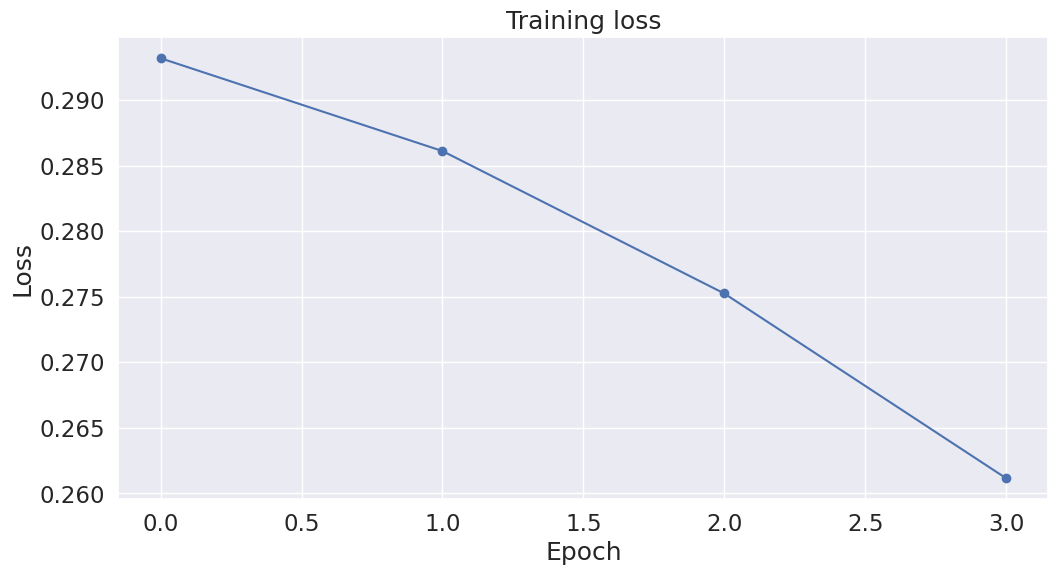

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()